In [ ]:
"""
create by: Kehan Wang
Date: 2020.6.26
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
df = pd.read_csv('nyc-rolling-sales.csv')
# df.head(100)
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


#1) Data Clean

First of all, we want to drop thoese useless columns and to check whether there are any duplicate values in our dataset. If there is any, we will need to drop them.

In [ ]:
# "Unname: 0" column looks like useless, drop it.
del df['Unnamed: 0']
#"EASE-MENT" column is empty, we are going to drop it.
del df['EASE-MENT']
# "Apartment Number" only has few values, so we are going to drop it.
print("The percent of rows with null in apartment number:" +str(sum(df['APARTMENT NUMBER']==' ')/len(df)))
del df['APARTMENT NUMBER']
del df['ADDRESS']
del df['SALE DATE']
del df['NEIGHBORHOOD']
del df['BUILDING CLASS AT PRESENT']
del df['BUILDING CLASS AT TIME OF SALE']

The percent of rows with null in apartment number:0.7746605478544732


In [ ]:
sum(df.duplicated(df.columns))
df = df.drop_duplicates(df.columns, keep='last')
df.shape

(81677, 14)

Now, Let's look into details.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81677 entries, 0 to 84547
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   BOROUGH                    81677 non-null  int64 
 1   BUILDING CLASS CATEGORY    81677 non-null  object
 2   TAX CLASS AT PRESENT       81677 non-null  object
 3   BLOCK                      81677 non-null  int64 
 4   LOT                        81677 non-null  int64 
 5   ZIP CODE                   81677 non-null  int64 
 6   RESIDENTIAL UNITS          81677 non-null  int64 
 7   COMMERCIAL UNITS           81677 non-null  int64 
 8   TOTAL UNITS                81677 non-null  int64 
 9   LAND SQUARE FEET           81677 non-null  object
 10  GROSS SQUARE FEET          81677 non-null  object
 11  YEAR BUILT                 81677 non-null  int64 
 12  TAX CLASS AT TIME OF SALE  81677 non-null  int64 
 13  SALE PRICE                 81677 non-null  object
dtypes: int

After browsing the information of dataset, we can see they use "-" to represent the missing values. Before prediction, we should clean these rows in the data table. Some of them should not be counted as the sale of real estate. For example, in column "SALE PRICE", these properties with 0 value might be transferred as a gift. 

Before cleaning missing values, We need to convert some of the columns(for example, SALE PRICE is object, SALE DATE is object, etc) to appropriate datatype.

In [ ]:
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
# df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['BOROUGH'] = df['BOROUGH'].astype('category')


In [ ]:
df.shape


(81677, 14)

In [ ]:
variables = df.columns

data = []
for variable in variables:
  l = df[variable].count()
  data.append(l)
available_per = np.round(pd.Series(data)/len(df), 3)

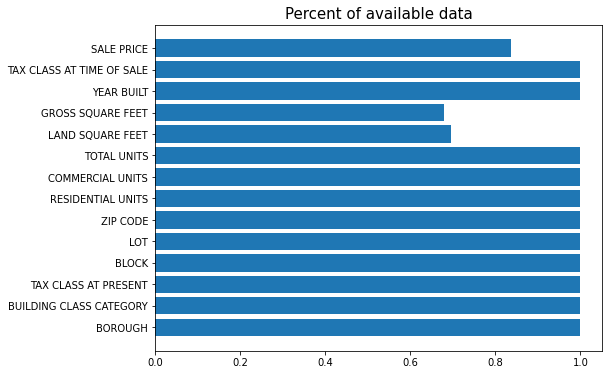

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(variables, available_per)
plt.title("Percent of available data", fontsize=15)
plt.show()

###TODO

As shown in the figure, SALE PRICE, GROSS SQUARE FEET and LAND SQUARE FEET have the lowest percent of available data. But again, SALE PRICE is the value we wanted to predict, we can still predict the price with all other features. For those SQUARE FEET, in this case, we will use mean values to fill them up.

In [ ]:
# df['SALE PRICE'] = df['SALE PRICE'].fillna(0)
# sale_house = df[~df['SALE PRICE'].isin([0])]
# sale_house = df[df['SALE PRICE'].notnull()]
# sale_house.shape #(69607,19) ->  Total 84548 - 69607 = 14941 lines have been deleted. 
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [ ]:
df['SALE PRICE'] = df['SALE PRICE'].fillna(0)
sale_house = df[~df['SALE PRICE'].isin([0])]
sale_house.shape #(69607,19) ->  Total 84548 - 69607 = 14941 lines have been deleted. 


(58865, 14)

Now Let's recap and revisit the details of dataset

In [ ]:
sale_house.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
count,58865.000000,58865.000000,58865.000000,58865.000000,58865.000000,58865.000000,5.886500e+04,5.886500e+04,58865.000000,58865.000000,5.886500e+04
mean,4154.602107,393.924267,10704.200221,1.714177,0.155644,1.882188,3.753246e+03,3.576840e+03,1808.804757,1.623953,1.509312e+06
std,3572.550581,673.116462,1270.730634,13.467234,9.730267,16.725767,3.575600e+04,2.363769e+04,507.844508,0.705565,1.241577e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000e+00
25%,1278.000000,21.000000,10301.000000,0.000000,0.000000,0.000000,2.000000e+03,1.300000e+03,1920.000000,1.000000,3.750000e+05
50%,3168.000000,51.000000,11207.000000,1.000000,0.000000,1.000000,3.600000e+03,2.500000e+03,1940.000000,2.000000,6.309000e+05
75%,6099.000000,1002.000000,11356.000000,2.000000,0.000000,2.000000,3.863020e+03,3.888377e+03,1966.000000,2.000000,1.085000e+06
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,4.000000,2.210000e+09


According to the above chart, we can observe that 

1) The min value for ZIP CODE is 0, we don't have ZIP CODE that equals to 0

2) The Building Year of some properties are 0, this should be incorrect as well.

3) Some properties have 0 SQUARE FEET...

Let's fix them

####TODO

#2) Preparation

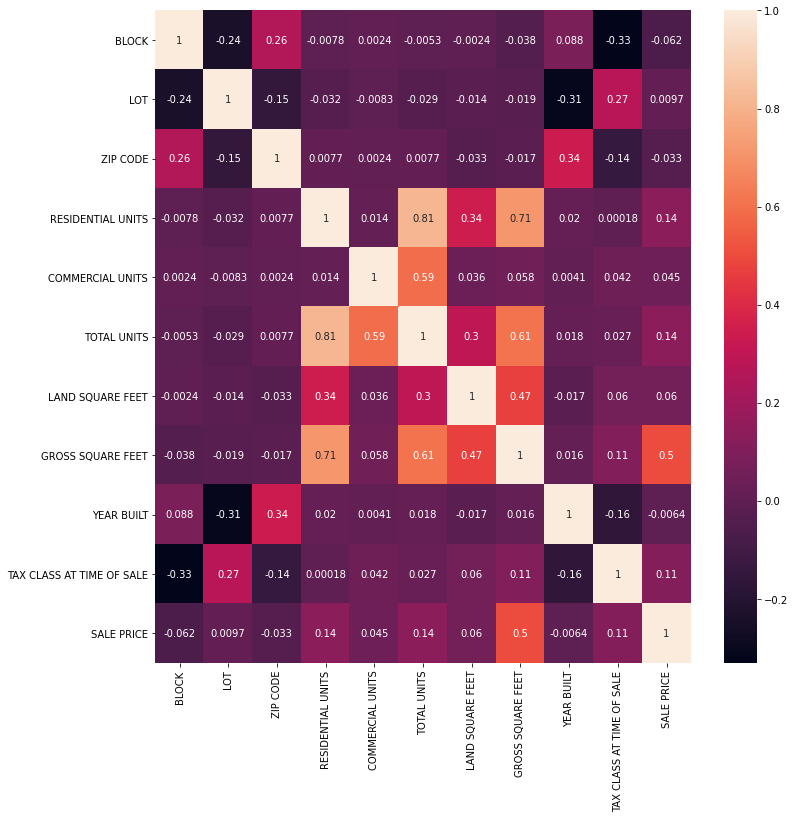

In [ ]:
cor = sale_house.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot=True, ax = ax)

Removing highing correlated independent variable from datasets.

In [ ]:
sale_house.drop(['RESIDENTIAL UNITS','GROSS SQUARE FEET',],inplace=True, axis=1)
sale_house.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,BOROUGH,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
0,1,07 RENTALS - WALKUP APARTMENTS,2A,392,6,10009,0,5,1633.0,1900,2,6625000.0
3,1,07 RENTALS - WALKUP APARTMENTS,2B,402,21,10009,0,10,2272.0,1913,2,3936272.0
4,1,07 RENTALS - WALKUP APARTMENTS,2A,404,55,10009,0,6,2369.0,1900,2,8000000.0
6,1,07 RENTALS - WALKUP APARTMENTS,2B,406,32,10009,0,8,1750.0,1920,2,3192840.0
9,1,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,10009,0,24,4489.0,1920,2,16232000.0


In [ ]:
#one hot encoded
#https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']

In [ ]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(sale_house[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58865 entries, 0 to 84547
Data columns (total 63 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   TAX CLASS AT TIME OF SALE                                             58865 non-null  int64
 1   BOROUGH_1                                                             58865 non-null  uint8
 2   BOROUGH_2                                                             58865 non-null  uint8
 3   BOROUGH_3                                                             58865 non-null  uint8
 4   BOROUGH_4                                                             58865 non-null  uint8
 5   BOROUGH_5                                                             58865 non-null  uint8
 6   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       58865 non-null  uint8
 7   BUILDING CLAS

In [ ]:
numeric_data=sale_house.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
count,58865.000000,58865.000000,58865.000000,58865.000000,58865.000000,5.886500e+04,58865.000000,58865.000000,5.886500e+04
mean,4154.602107,393.924267,10704.200221,0.155644,1.882188,3.753246e+03,1808.804757,1.623953,1.509312e+06
std,3572.550581,673.116462,1270.730634,9.730267,16.725767,3.575600e+04,507.844508,0.705565,1.241577e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000e+00
25%,1278.000000,21.000000,10301.000000,0.000000,0.000000,2.000000e+03,1920.000000,1.000000,3.750000e+05
50%,3168.000000,51.000000,11207.000000,0.000000,1.000000,3.600000e+03,1940.000000,2.000000,6.309000e+05
75%,6099.000000,1002.000000,11356.000000,0.000000,2.000000,3.863020e+03,1966.000000,2.000000,1.085000e+06
max,16319.000000,9106.000000,11694.000000,2261.000000,2261.000000,4.252327e+06,2017.000000,4.000000,2.210000e+09


In [ ]:
df = sale_house
scaler = StandardScaler()
scaler.fit(df[numeric_data.columns])
scaled = scaler.transform(df[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       df[col] = scaled[:,i]

In [ ]:

df.drop(one_hot_features,axis=1,inplace=True)
df = pd.concat([df, one_hot_encoded] ,axis=1)
df.head()

,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,YEAR BUILT,SALE PRICE,TAX CLASS AT TIME OF SALE,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11 SPECIAL CONDO BILLING LOTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_17 CONDO COOPS,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_25 LUXURY HOTELS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_34 THEATRES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_39 TRANSPORTATION FACILITIES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS,TAX CLASS AT PRESENT_,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4
0,-1.053207,-0.576316,-0.547092,-0.015996,0.186409,-0.059298,0.179575,0.412035,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-1.050408,-0.554031,-0.547092,-0.015996,0.485352,-0.041427,0.205173,0.195476,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,-1.049848,-0.503519,-0.547092,-0.015996,0.246198,-0.038714,0.179575,0.522782,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,-1.049288,-0.537689,-0.547092,-0.015996,0.365775,-0.056026,0.218957,0.135597,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,-1.054606,-0.357927,-0.547092,-0.015996,1.322391,0.020577,0.218957,1.185816,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# classifying data into independent and dependent variable
X = df.drop(['SALE PRICE'],axis = 1).values
y = df['SALE PRICE'].values

In [ ]:
# creating test and training set data, 70% train, 30% test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#3) Predition

##3.0)Helper Function

In [ ]:
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

##3.1) Linear

##3.2)Ridge

In [ ]:

# fitting linear regression to training set
regressor = Ridge(alpha=0.01, normalize=True)
regressor.fit(X_train,y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred = regressor.predict(X_test)
result = rmse(y_test, y_pred)
result

0.5851199455918485

##3.3)Random Forest

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = dtree.predict(X_test)
result = rmse(y_test, y_pred)
result

0.6086380072949652

In [ ]:
dforest = RandomForestRegressor(n_estimators=3000, criterion='mse', bootstrap=True, n_jobs=-1)
dforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=3000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = dforest.predict(X_test)
result = rmse(y_test, y_pred)
result

0.4860193036299752

##3.4)Gradient boosting